## Введение в глубокое обучение
### Занятие 8. Задача машинного перевода (seq2seq). Механизм Attention.

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

##### Credits: 
* Первая часть данного занятия основана на [ноутбуке о задаче машинного перевода](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) в переводе Vasiliy Es'kin (github: [vasiliyeskin](https://github.com/vasiliyeskin)).**
* **Автор [оригинального ноутбука](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb): Ben Trevett (github: [bentrevett](https://github.com/bentrevett)).**

#### План занятия:
1. Обработка последовательностей с помощью RNN в задаче машинного перевода.
2. Механизм внимания в нейронных сетях (Attention)
3. BERT в задаче классификации текстов


### 1. Обработка последовательностей с помощью RNN в задаче машинного перевода.

В данном занятии будет рассмотрена модель из статьи [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215).


![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq1.png?raw=1)

На изображении выше показан пример перевода. Предложение ввода/источника, «guten morgen», проходит через слой эмбеддинга (желтый, служит для сопоставления элементов речи (слова, предложения,...) числовому вектору), а затем вводится в кодировщик (зеленый). Всегда добавляются токены *начало последовательности* (`<sos>` — *start of sequence*) и *конец последовательности* (`<eos>` — *end of sequence*) в начало и конец предложения соответственно. На каждом временном шаге на вход в RNN кодировщика подаётся как эмбеддинг-версия текущего слова $ e (x_t)$, которая порождена слоем эмбеддинга $ e $, так и скрытое состояние из предыдущего временного шага, $ h_{t-1} $. На выход RNN кодировщика подаёт новое скрытое состояние $ h_t $.

## Подготовка данных

Для предобработки будут использоваться библиотеки `torchtext` и `nltk`.

Загрузим параллельный корпус текстов. Это [корпус Multi30k](https://github.com/multi30k/dataset), который представляет собой набор данных из ~30 000 параллельных предложений на английском, немецком и французском языках.

In [1]:
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 4.2 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x39960000 @  0x7fce7c531615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does no

In [2]:
from torchtext.datasets import Multi30k


train_iter = Multi30k(split="train")

# torchtext.datasets.DatasetName yield exhaustible IterableDataset.
# To fix this we convert our dataset to a list.
train_data = list(train_iter)

print(f"Number of training examples: {len(train_data)}")
print(train_data[0])

100%|██████████| 1.21M/1.21M [00:01<00:00, 933kB/s] 


Number of training examples: 29000
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n', 'Two young, White males are outside near many bushes.\n')


Реализуем токенизаторы. Они используется для превращения строки, содержащей предложение, в список отдельных токенов, составляющих эту строку, например "доброе утро!" становится ["доброе", "утро", "!"].

In [3]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize("good morning!"))

['good', 'morning', '!']


Теперь реализуем отдельную функцию для токенизации:

In [4]:
def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())

src, trg = train_data[0]


print(tokenize(src))
print(tokenize(trg))

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


Построим словари (множества уникальных токенов) для исходного и целевого языков. Будем учитывать токены, которые встречаются не реже `min_freq` раз.
Словарь используется для связывания каждого уникального токена с индексом (целым числом). Словари исходного и целевого языков различаются.

In [5]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)
trg_vocab = Vocab(trg_counter, min_freq=2)

Добавим технические токены. Токен `<UNK>` будет использоваться для обозначения токенов, которые не присутствовали в словаре, построенном по обучающей выборке.

In [6]:
unk_token = "<UNK>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

Также добавим технические токены начала строки `<SOS>`, конца строки `<EOS>` и паддинга `<PAD>`.

In [7]:
sos_token, eos_token, pad_token = "<SOS>", "<EOS>", "<PAD>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

Оценим полученный размер словаря

In [8]:
print(f"Unique tokens in source (de) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (de) vocabulary: 7892
Unique tokens in target (en) vocabulary: 5903


Наконец, реализуем простую функцию `encode` для приведения последовательности к формату, с которым могут работать нейронные сети. Она объединяет все предыдущие наработки.

In [9]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

print(encode(src, src_vocab)[::-1])
print(encode(trg, trg_vocab))

[7890, 13, 180, 6, 457, 33, 1596, 15, 46, 0, 236, 423, 157, 249, 193, 210, 3358, 33, 687, 8, 25, 18, 7889]
[5900, 18, 28, 14, 284, 89, 18, 1573, 30, 214, 256, 38, 534, 71, 18, 1051, 659, 3, 61, 1549, 89, 1421, 14, 38, 181, 11, 5901]


Последний шаг подготовки данных — создание итераторов. С их помощью можно итерационно возвращать пакеты данных, которые будут иметь атрибут `src` (тензоры PyTorch, содержащие набор оцифрованных исходных предложений) и атрибут `trg` (тензоры PyTorch, содержащие набор оцифрованных целевых предложений). Оцифрованные предложения — это просто причудливый способ сказать, что они были преобразованы из последовательности читаемых токенов в последовательность соответствующих индексов с использованием словаря.

In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        # Encode src and trg sentences, convert them into a tensor
        # and store them in src_list and trg_list respectively.
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    # Pad sequences with pad_sequence function.
    # src_padded = pad_sequence(...)
    # trg_padded = pad_sequence(...)
    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


batch_size = 256
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([30, 256]), torch.Size([34, 256]))

Отлично! Теперь мы можем генерировать батчи для обработки данных из обучающей выборки. Аналогичным образом обработаем валидационную выборку:

In [11]:
val_data = list(Multi30k(split="valid"))
val_dataloader = DataLoader(val_data, batch_size, collate_fn=collate_batch)

100%|██████████| 46.3k/46.3k [00:00<00:00, 233kB/s]


## Построение модели Seq2Seq

Модель состоит из двух частей: энкодер, декодер. Затем они будут объединены в одну модель Seq2seq.

### Энкодер

Энодер — это двухслойная LSTM сеть. В оригинальной статье используется четырехслойная LSTM, но в целях экономии времени она была упрощена.

Визуально энкодер выглядит следующим образом:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq2.png?raw=1)

Ему будет соответствовать класс `Encoder`. Конструктор данного класса принимает следующие аргументы:
- `input_dim` - размер / размерность one-hot векторов, которые будут вводиться в кодировщик. Они равны размеру входного (исходного) размера словаря.
- `emb_dim` - размерность слоя эмбеддинга. Этот слой преобразует one-hot векторы в dense векторы с размерами `emb_dim`.
- `hid_dim` - размерность скрытого состояния и состояния ячейки.
- `n_layers` - количество слоев в RNN.
- `dropout` - количественная характеристика дропаута. Это параметр регуляризации для предотвращения переобучения. [Здесь]((https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR)) можно коротко вспомнить, что это такое/

Следует отметить, что аргумент `dropout` для LSTM заключается в том, сколько связей необходимо отключить между уровнями многослойной RNN, то есть между скрытыми состояниями, выводимыми из уровня $ l $, и теми же скрытыми состояниями, используемыми для ввод слоя $ l + 1 $.

RNN возвращает: `outputs` (скрытые состояния верхнего уровня для каждого временного шага), `hidden` (окончательное скрытое состояние для каждого слоя, $h_T$, наложенное друг на друга) и `cell` (конечное состояние ячейки для каждого слоя, $c_T$, наложенных друг на друга).

Размеры каждого из тензоров оставлены в виде комментариев в коде. В этой реализации `n_directions` всегда будет 1. Обратите внимание, существуют и двунаправленные RNN, и они могут иметь` n_directions` равное 2.

In [12]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        # Define embedding, dropout and LSTM layers.
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        # src has a shape of [seq_len, batch_size]
        
        # Compute an embedding from src data and apply dropout.
        # embedded should have a shape of [seq_len, batch_size, emb_dim]
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)

        # Compute the RNN output values.
        # When using LSTM, hidden should be a tuple of two tensors:
        # 1) hidden state
        # 2) cell state
        # both of shape [n_layers * n_directions, batch_size, hid_dim]
        _, hidden = self.rnn(embedded)

        return hidden

### Декодер

Декодер также будет представлен двуслойной LSTM. Иллюстрация декодера доступна ниже:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq3.png?raw=1)

Основное отличие декодера от энкодера в том, что он принимает начальное скрытое состояние от энкодера, что позволяет передать информацию о рассматриваемом предложении декодеру.

Аргументы и инициализация аналогичны классу `Encoder`, за исключением `output_dim`, который является размером словаря для выходной/целевой последовательности. Кроме того, добавлен слой `Linear`, используемый для прогнозирования токена на основе скрытого состояния верхнего уровня.

In [13]:
class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Define embedding, dropout and LSTM layers.
        # Additionaly, Decoder will need a linear layer to predict next token.
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        # input has a shape of [batch_size]
        # hidden is a tuple of two tensors:
        # 1) hidden state
        # 2) cell state
        # both of shape [n_layers, batch_size, hid_dim]
        # (n_directions in the decoder shall always be 1)

        # Compute an embedding from input data and apply dropout.
        # Remember, that LSTM layer expects input to have a shape of
        # [seq_len, batch_size, emb_dim], which means that we need
        # to somehow introduce the seq_len dimension into our input tensor.
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        # Compute the RNN output values.

        output, hidden = self.rnn(embedded, hidden)
        # output has a shape of [seq_len, batch_size, hid dim]
        # Compute logits for the next token probabilities from RNN output.
        pred = self.out(output.squeeze(dim=0))

        # should have a shape [batch_size, n_tokens]
        return pred, hidden

### Seq2Seq

Наконец, энкодер и декодер могут быть объединены в класс `Seq2Seq`. Данный класс работает сразу с предложениями как в исходном, так и в целевом языке.
Иллюстрация всей модели доступна ниже:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq4.png?raw=1)

In [14]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src has a shape of [src_seq_len, batch_size]
        # trg has a shape of [trg_seq_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing, e.g. if
        # teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.n_tokens

        # tensor to store decoder predictions
        preds = []

        # Last hidden state of the encoder is used as
        # the initial hidden state of the decoder.
        hidden = self.encoder(src)

        # First input to the decoder is the  token.
        input = trg[0, :]

        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

### Обучение модели Seq2Seq

Процедура обучения модели имеет мало отличий от предыдущих занятий.
Также необходимо определить `torch.device`. Она используется, чтобы указать, на каком устройстве будут происходить вычисления: на GPU или на CPU. Обратимся к функции `torch.cuda.is_available()`, которая вернет `True`, если был обнаружен графический процессор.

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)

Оценим количество параметров в модели:

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,916,175 trainable parameters


Функции потерь необходимо указать, что некоторые токены не стоит учитывать при подсчете ошибки. Для этого укажем `ignore_index` равный `<pad>`.

In [17]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

Наконец, обучим нашу модель.
Не забывайте, что для оценки на отложенной выборке, модель необходимо перевести в режим inference с помощью `model.eval()`.  Также будем использовать `with torch.no_grad()`, чтобы гарантировать, что градиенты не вычисляются на этапе валидации.

In [18]:
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm, trange


n_epochs = 10
clip = 1
for epoch in trange(n_epochs, desc="Epochs"):
    model.train()
    train_loss = 0
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False):
        # Use model to get prediction and compute loss using criterion.
        # After you've computed loss, zero gradients, run backprop, clip
        # gradients and update model with optimizer.
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch} train loss = {train_loss} ")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False):
            # Once again compute model prediction and loss, but don't
            # try and update model parameters with it.
            # Just use it for model evaluation.
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoch} val loss = {val_loss} ")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 0 train loss = 5.211786629860861 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 val loss = 4.751313090324402 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 1 train loss = 4.675335946835969 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 val loss = 4.364145874977112 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 2 train loss = 4.400121270564565 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 val loss = 4.153704881668091 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 3 train loss = 4.18196029412119 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 val loss = 3.9965034127235413 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 4 train loss = 4.0025258900826435 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 val loss = 3.9151538610458374 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 5 train loss = 3.853799665183352 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 val loss = 3.71134215593338 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 6 train loss = 3.698231080122161 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 val loss = 3.636529803276062 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 7 train loss = 3.594908929707711 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 val loss = 3.4987143874168396 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 8 train loss = 3.479577869699712 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 val loss = 3.3533562421798706 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 9 train loss = 3.3858052513055634 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 val loss = 3.16286438703537 


Оценим качество перевода визуально. Для этого воспользуемся первыми десятью элементами из валидационной выборки:

In [19]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for src, trg in val_data[:10]:
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

src: 'eine gruppe von männern lädt baumwolle auf einen lastwagen'
trg: 'a group of men are loading cotton onto a truck'
pred: 'a is standing on a street with a a .'

src: 'ein mann schläft in einem grünen raum auf einem sofa.'
trg: 'a man sleeping in a green room on a couch.'
pred: 'a man is standing on a a a a a white shirt .'

src: 'ein junge mit kopfhörern sitzt auf den schultern einer frau.'
trg: 'a boy wearing headphones sits on a woman's shoulders.'
pred: 'a man is standing on a sidewalk while a man in a black shirt .'

src: 'zwei männer bauen eine blaue eisfischerhütte auf einem zugefrorenen see auf'
trg: 'two men setting up a blue ice fishing hut on an iced over lake'
pred: 'a is on the sidewalk , a a a a a a a .'

src: 'ein mann mit beginnender glatze, der eine rote rettungsweste trägt, sitzt in einem kleinen boot.'
trg: 'a balding man wearing a red life jacket is sitting in a small boat.'
pred: 'a man standing in a a with a man in a black shirt and a .'

src: 'eine frau in ei

В результате, можно сформулировать следующие выводы:
* Архитектура энкодер-декодер является общим подходом к работе с данными сложной структуры.
* Рекуррентные сети способны улавливать последовательную структуру данных благодаря своей архитектуре.
* Даже сложные задачи могут быть декомпозированы на несколько простых подзадач.

### 2. Механизм внимания в нейронных сетях (Attention)

__Go to slides__

### 3. BERT в задаче классификации текстов

*Credits: last part of this notebook belongs to Jay Alammar and his [great blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) (while it has minor changes). His blog is a great way to dive into the DL and NLP concepts.*

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

Далее мы воспользуемся предобученной языковой моделью BERT и воспользуемся ей для решения уже знакомой вам задачи классификации текстов с использованием датасета SST-2.

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Процесс решения задачи можно разделить на два основных этапа:

* DistilBERT обрабатывает текст отзывов и представляет в виде вектора фиксированной размерности (768). DistilBERT – упрощенная версия модели BERT, полученная с помощью техники [дистилляции](https://www.cs.toronto.edu/~hinton/absps/distillation.pdf).

* Простая логистическая регрессия использует полученные признаковые описания для решения задачи классификации.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

Пример данных (уже знакомых вам) доступен ниже:

<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>


Также там понадобится замечетельная библиотека `transformers` которая предоставляет доступ к огромному числу предобученных моделей для работы с текстом.

In [21]:
!pip install -Uqq transformers

     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 54.5 MB/s 
     |████████████████████████████████| 182 kB 73.0 MB/s 


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

Для простоты рассмотрим только первые 2000 объектов:

In [24]:
batch = df[:2000]

Выборку можно считать сбалансированной:

In [25]:
batch[1].value_counts()

1    1041
0     959
Name: 1, dtype: int64

Загрузим предобученную модель:

In [26]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Для токенизации обратимся к уже существующему токенизатору. Именно он должен использоваться для токенизации текста, если планируется использование предобученной модели BERT.

In [27]:
tokenized = batch[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

С помощью padding приведем все предложения к единой длине. В общем случае стоит делать это для каждого батча отдельно, но в данном случае мы преследуюем максимальую простоту кода.

In [28]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Переменная `padded` представляет собой предобработанную версию датасета.
Ниже мы можем видеть, что `<PAD>` токенов впрямь очень много:

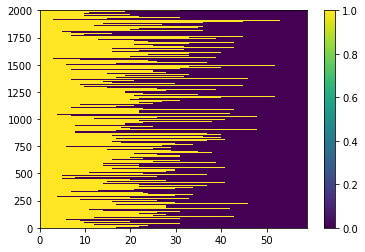

In [29]:
plt.pcolormesh(padded>0)
plt.colorbar()

Также необходимо указать, какие из токенов не стоит учитывать при вычислении Attention. Для этого воспользуемся маской:

In [30]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

Наконец, предобработаем текст с помощью BERT.
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

In [31]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
model.eval()
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Нас интересует лишь один вектор для каждого текста. Он стоит на первой позиции и соответствует`[CLS]` (classification) токену.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

In [33]:
features = last_hidden_states[0][:,0,:].numpy()
labels = batch[1]

Теперь обучим классическую логистическую регрессию из `sklearn`. Перед этим разобьем выборку на `train` и `test`.

In [34]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

In [35]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

Оценим качество классификации:

In [36]:
lr_clf.score(train_features, train_labels)

0.9186666666666666

In [37]:
lr_clf.score(test_features, test_labels)

0.82

In [38]:
def visualize_roc(model, X_train, X_test, y_train, y_test):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
        auc = roc_auc_score(y, proba)

        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

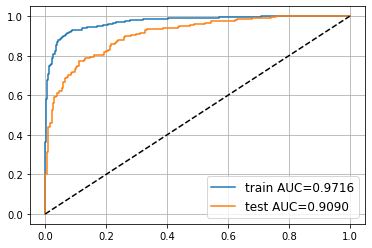

In [39]:
visualize_roc(lr_clf, train_features, test_features, train_labels, test_labels)

Полученное качество достаточно высокое, и модель не показывает явных признаков переобучения. При этом мы использовали лишь подвыборку в 2000 объектов (до разбиения), а не весь набор данных.

#### Выводы:
* Механизм внимания (Attention) позволяет оценивать (и выделять) значимость различных элементов последовательностей друг для друга.
* Механизм внимания может быть использован как в задачах обработки текстов, так и при работе с другими данными, обладающими сложной структурой (изображения, видео, графы и др.)
* В настоящий момент архитектуры, основанные на чуть измененном механизме внимания (Self-attention) показывают state of the art результаты во множестве задач.
* Предобученные модели позволяют использовать "знания", полученные в других задачах. Их использование значительно упрощает решение прикладных задач.
* Многие подходы на самом деле похожи друг на друга и исходят из похожих (и достаточно простых) предположений.